In [2]:
from dispatches.models.renewables_case.RE_flowsheet import *


## Creating the Superstructure Flowsheet with Wind, PEM Electrolyzer, Battery, H2 Tank and H2 Turbine Unit Models

To create a design superstructure that contains all the technologies with which we are considering to hybridize the existing wind farm, there is the `create_model` function in `RE_flowsheet.py` which creates a Pyomo ConcreteModel for a single timestep and adds to it all the unit models, which are connected via Arcs.

This flowsheet model can be created with any of the units models excluded: the simplest flowsheet contains only the wind plant, whereas the full flowsheet contains a PEM electrolzer, battery, hydrogen storage tank, and a hydrogen turbine arranged in the below configuration:

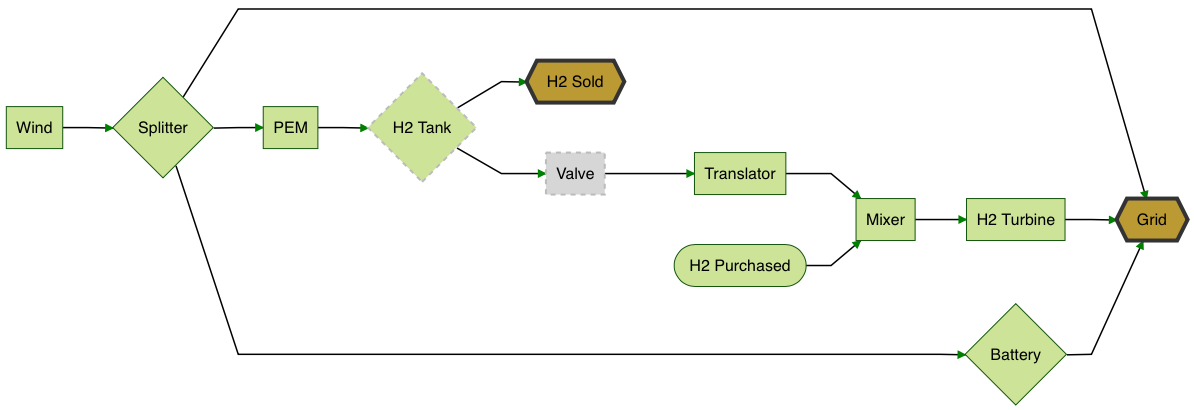

In this graph, all the green and grey nodes represent IDAES unit models whereas the tan nodes are "markets" whose sales will be optimized in the later section on Objectives. The unit models have at least a size parameter that can be optimized. The rectangular nodes are unit models with no control variables, whereas the diamond nodes have operating variables whose values need to be decided. The oval node is a slack variable that allows the hydrogen flow into the turbine to be non-zero. There are 3 different ways to model the hydrogen tank, depending on which of the grey-bordered nodes are used; see the `add_h2_tank` section below.

The `create_model` function's documentation can be found in-line with the code, and is shown below.

In [2]:
help(create_model)

Help on function create_model in module dispatches.models.renewables_case.RE_flowsheet:

create_model(wind_mw, pem_bar, batt_mw, tank_type, tank_length_m, turb_inlet_bar, wind_resource_config=None)
    Creates a Flowsheet Pyomo model that puts together the Wind unit model with optional PEM, Hydrogen Tank, and Hydrogen Turbine unit models.
    
    The input parameters determine the size of the technologies by fixing the appropriate variable. If the size parameter is None, the technology
    will not be added.
    
    The wind is first split among its output destinations: grid, battery and PEM with an ElectricalSplitter unit model. 
    After the PEM, a tank and turbine may be added. The `simple` tank model includes outlet ports for hydrogen flows to the turbine and the pipeline.
    The `detailed` tank model uses a Splitter unit model to split the material and energy flows to the turbine and to hydrogen sales.
    
    Args:
        wind_mw: wind farm capacity
        pem_bar: operati

The `create_model` function uses individual functions to add each unit model separately. Each of these individual functions has input parameters of size and sometimes an operating condition such as pressure. The unit models added to the flowsheet are created with a fixed size and operating condition, and these constraints or fixed values will be relaxed in later steps to allow those variables to be optimized.

The formulation of each of these models is described in the [DISPATCHES Documentation](https://dispatches.readthedocs.io/en/main/models/index.html)

In [3]:
# https://dispatches.readthedocs.io/en/main/models/renewables/wind_power.html
help(add_wind)

Help on function add_wind in module dispatches.models.renewables_case.RE_flowsheet:

add_wind(m, wind_mw, wind_resource_config=None)
    Adds a wind unit to the flowsheet with a fixed system capacity and that uses resource data to determine the capacity factors
    
    The resource data can be provided by configuring either `resource_speed` or `resource_probability_density`.
    The `resource_speed` is a list of wind speeds (m/s) per timestep of the flowsheet.
    The `resource_probability_density` is formatted as a 2d list where each row contains: (wind m/s, wind degrees from north clockwise, probability) 
    and the probabilities in all rows add up to 1.
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        wind_mw: capacity of wind model to be fixed
        wind_resource_config: dictionary of Windpower Config keys (`resource_speed`, `resource_probability_density`) and ConfigValues
    Returns:
        wind unit model in the flowsheet



In [5]:
# https://dispatches.readthedocs.io/en/main/models/renewables/pem_electrolyzer.html
help(add_pem)

Help on function add_pem in module dispatches.models.renewables_case.RE_flowsheet:

add_pem(m, outlet_pressure_bar)
    Adds a PEM electrolyzer unit to the flowsheet with a fixed outlet pressure and conversion rate. The properties package is h2_ideal_vap.
    
    The operating temperature and maximum pressure of the PEM are pulled from load_parameters.py
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        outlet_pressure_bar: operating pressure of the PEM
    Returns:
        PEM electrolyzer unit model in the flowsheet
        h2_ideal_vap property package in the flowsheet



In [6]:
# https://dispatches.readthedocs.io/en/main/models/renewables/battery.html
help(add_battery)

Help on function add_battery in module dispatches.models.renewables_case.RE_flowsheet:

add_battery(m, batt_mw)
    Adds a Battery unit to the flowsheet with a fixed power and duration of 4 hours.
    
    The charging and discharging efficiencies are set at 98%.
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        batt_mw: nameplate power
    Returns:
        battery unit model in flowsheet



In [7]:
# Detailed Tank: https://dispatches.readthedocs.io/en/main/models/nuclear/hydrogen_tank.html
# Simplified Tank: 
help(add_h2_tank)

Help on function add_h2_tank in module dispatches.models.renewables_case.RE_flowsheet:

add_h2_tank(m, tank_type='simple', valve_outlet_bar=None, length_m=None)
    Adds a Hydrogen Tank unit to the flowsheet, with 3 options for the model type: `simple`, `detailed` and `detailed-valve`.
    
    For the `simple` type, the model is linear with no energy balances.
    For the `detailed` type, the model is nonlinear with energy balances deactivated. The capacity of the tank is determined by its 
    geometry.
    For the `detailed-valve` type, the `detailed` model is used, but with energy balances active and with a Valve unit. 
    The valve coefficient is pulled from load_parameters but needs to be be tuned per application.
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        tank_type: `simple`, `detailed`, or `detailed-valve`
        valve_outlet_bar: required if not using `simple` type, outlet pressure of the valve
        length_m: required if using `detailed

In [8]:
# https://dispatches.readthedocs.io/en/main/models/nuclear/hydrogen_turbine.html
help(add_h2_turbine)

Help on function add_h2_turbine in module dispatches.models.renewables_case.RE_flowsheet:

add_h2_turbine(m, inlet_pres_bar)
    Adds a hydrogen turbine unit to the flowsheet, using the h2_reaction_props property package.
    
    A translator and mixer unit is added also. The mixer adds an `air_feed` and an `purchased_hydrogen_feed` to the `hydrogen_feed`.
    The air_feed contains oxygen at a fixed ratio relative to the inlet hydrogen flow rate, `air_h2_ratio`, from load_parameters.
    .The purchased_hydrogen_feed allows the turbine hydrogen inlet flow rate to be `h2_turb_min_flow`, which helps
    with the model solve.
    
    The `compressor_dp` is fixed from load_parameters, the compressor's isentropic efficiency is 0.86, 
    the stoichiometric conversion rate of hydrogen is 0.99, and the turbine's isentropic efficiency is 0.89.
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        inlet_pres_bar: operating pressure of inlet air and hydrogen to the mixe

In [3]:
# Example flowsheet creation

wind_mw = 200
pem_bar = 1.01325
batt_mw = 50
tank_type = "simple"
h2_turb_bar = 24.7
tank_length_m = None

m = create_model(wind_mw, pem_bar, batt_mw, tank_type, tank_length_m, h2_turb_bar, wind_resource_config=wind_resource[0]['wind_resource_config'])

m.fs.battery.report()


Unit : fs.battery                                                          Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                               Inlet  Outlet   kWh 
    electricity               0.0000  0.0000      -
    initial_state_of_charge        -       - 0.0000
    initial_energy_throughput      -       - 0.0000
    state_of_charge                -       - 0.0000
    energy_throughput              -       - 0.0000


## Linking Flowsheets into a Dynamic Model with MultiPeriod Model

The `MultiPeriodModel` class is used to link flowsheet models representing a single time point into sequential periods of time. 

The `

In [4]:
from dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP import *
help(MultiPeriodModel)

Interactive Python mode detected; using default matplotlib backend for plotting.
Help on class MultiPeriodModel in module idaes.apps.grid_integration.multiperiod.multiperiod:

class MultiPeriodModel(builtins.object)
 |  MultiPeriodModel(n_time_points, process_model_func, linking_variable_func, periodic_variable_func=None)
 |  
 |  The `MultiPeriodModel` class helps transfer existing steady-state
 |  process models to multiperiod versions that contain dynamic time coupling.
 |  
 |  Arguments:
 |      n_time_points: number of points to use in time horizon
 |      process_model_func: function that returns a multiperiod capable pyomo model
 |      linking_variable_func: function that returns a tuple of variable
 |                             pairs to link between time steps
 |      periodic_variable_func: a function that returns a tuple of variable
 |                              pairs to link between last and first time steps
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n_time_

In [6]:
help(wind_battery_pem_tank_turb_variable_pairs)

Help on function wind_battery_pem_tank_turb_variable_pairs in module dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP:

wind_battery_pem_tank_turb_variable_pairs(m1, m2, tank_type)
    This function links together unit model state variables from one timestep to the next.
    
    The hydrogen tank and the battery model have material and energy holdups that need to be consistent across time blocks.
    If using the `simple` tank model, there are no energy holdups to account for. For the `detailed` tank model, the emergy
    holdups need to be linked.
    
    Args:
        b1: current time block
        b2: next time block



In [7]:
help(wind_battery_pem_tank_turb_periodic_variable_pairs)

Help on function wind_battery_pem_tank_turb_periodic_variable_pairs in module dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP:

wind_battery_pem_tank_turb_periodic_variable_pairs(m1, m2, tank_type)
    The final hydrogen material holdup and battery storage of charge must be the same as in the intial timestep. 
    If using the `simple` tank model, there are no energy holdups to account for. For the `detailed` tank model, the emergy
    holdups need to be linked.
    
    Args:
        b1: final time block
        b2: first time block



In [5]:
wind_resource = { 'resource_speed': 10 }
                 
input_params = {
    "wind_mw": fixed_wind_mw,
    "wind_mw_ub": wind_mw_ub,
    "batt_mw": fixed_batt_mw,
    "pem_mw": fixed_pem_mw,
    "pem_bar": pem_bar,
    "pem_temp": pem_temp,
    "tank_size": fixed_tank_size,
    "tank_type": "simple",
    "turb_mw": turb_p_mw,

    "wind_resource": wind_resource,
    "h2_price_per_kg": h2_price_per_kg,
    "DA_LMPs": prices_used,

    "design_opt": True,
    "extant_wind": True
}
                 
m = wind_battery_pem_tank_turb_model(wind_resource, input_params, verbose=False)

2022-06-10 14:21:27 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.


In [6]:
# Display the current state of the flowsheet

m.fs.windpower.display()
m.fs.splitter.report()
m.fs.battery.report()
m.fs.pem.report()
m.fs.h2_tank.display()
m.fs.h2_turbine.report()

Block fs.windpower

  Variables:
    system_capacity : Rated system capacity of wind farm
        Size=1, Index=None, Units=kW
        Key  : Lower : Value    : Upper : Fixed : Stale : Domain
        None :     0 : 847000.0 :  None :  True :  True : NonNegativeReals
    electricity : Electricity production
        Size=1, Index=fs._time, Units=kW
        Key : Lower : Value            : Upper : Fixed : Stale : Domain
        0.0 :     0 : 509612.584367394 :  None : False :  True : NonNegativeReals

  Objectives:
    None

  Constraints:
    elec_from_capacity_factor : Size=1
        Key : Lower : Body : Upper
        0.0 :   0.0 :  0.0 :   0.0

Unit : fs.splitter                                                         Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                   Inlet     Outlet  
    electricity 5.0961e+05          -
    grid                 - 5.0961e+05
    pem                  -     0.0000
    batt

## Optimizing for Net Present Value

The function `wind_battery_pem_tank_turb_optimize` creates the MultiPeriodModel and adds the sizing and operating constraints in addition to the Net Present Value Objective.



2022-06-10 14:24:54 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
{'wind_mw': 947.0562995352549, 'batt_mw': 1329.7720425632272, 'pem_mw': 0.017710350135957207, 'tank_kgH2': 1.5193066314063957, 'turb_mw': 0.0045987577821088865, 'avg_turb_eff': 1.5143160864345608, 'annual_rev_h2': 1892.5850241091466, 'annual_rev_E': 191106712.4876058, 'NPV': 1350125249.6829383}


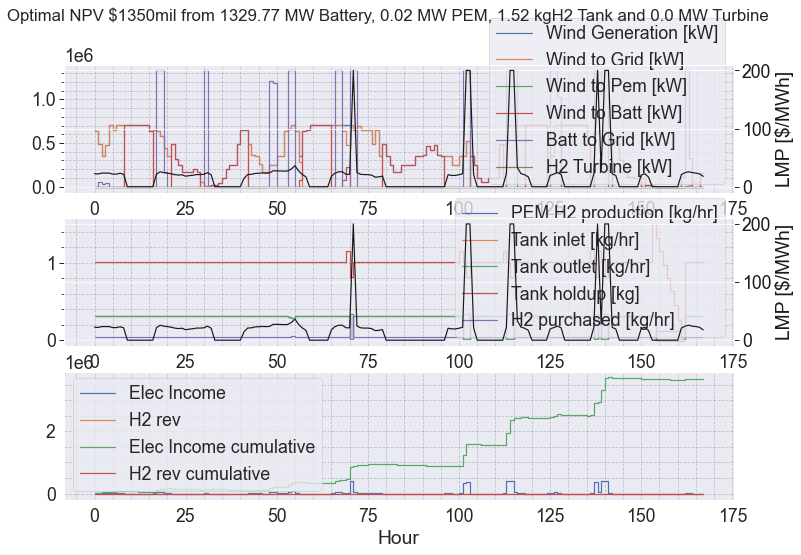

In [8]:
input_params['wind_resource'] = {t:
                    {'wind_resource_config': {
                         'resource_speed': [wind_speeds[t]]
                    }
                } for t in range(8760)}

design_res = wind_battery_pem_tank_turb_optimize(7 * 24, input_params, verbose=False, plot=True)